Monte Carlo is a learning method for estimating value functions and discovering optimal policy. Unlike dynamic programming seen previously, this method does not require complete knowledge of the environment - _environment dynamics given by four-argument parameter $p$_. Monte Carlo method requires _experience_ - sample sequence of state, action, rewards by interacting with environment.<br>
Monte Carlo method averages over the returns seen in a particular state. To ensure that well-defined returns are available, here we define Monte Carlo methods for episodic tasks.<br>
- Experiance is divided into _episodes_ and episodes always end up in a terminal state no matter what actions are chosen

Monte Carlo method can be seen as multiple _Bandits_, each for a particular state. Since return after taking some action in one state depends of the actions taken in later states in the same episode. Because all the action selections are undergoing learning, the problem becomes nonstationary from the point of view of the earlier state.

## Monte Carlo prediction
Recall that value of each state is the expected return - cumulative future discounted reward starting from that state. So to find the expected return from experience we can average over the returns seen in state $s$.<br>
Particularly, we need to estimate $v_\pi(s)$, that is value of state $s$ under policy $\pi$ given a set of episodes obtained by following policy $\pi$. Each occurance to state $s$ is called _visit_ to $s$. In an episode state $s$ might be visited multiple times; so we are calling the first time we visit $s$, _first visit_. __first-visit MC__ estimates $v_\pi(s)$ following first visit to $s$. Whereas the __every-visit MC__ method averages the returns following all visits to $s$.

### Blackjack Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
EXCEED = 21
FACE_CARD = 10
DISCOUNT = 1
CARDS = [x for x in range(1, 11)] * 4 + [FACE_CARD for _ in range(4 * 3)]

In [3]:
# Each state shows total of the player's cards from [12, 21] and the dealers showing cards (Ace-10) and whether or not he own a usable ace
state_value = np.zeros((22, 11, 2), dtype=np.int32)
state = [0, 0, 0] # player's total, dealers first card, usable ace respectively

# Example states: policy is that player sticks if player's sum is 20 or 21, otherwise hits
policy = np.zeros_like(state_value, dtype=np.int32)
policy[[20, 21], :, :] = 1

In [4]:
def init_player():
    state = [0, 0, 0]
    # players first card
    card = np.random.choice(CARDS)
    if card == 1: 
        state[0] += 11
        state[2] += 1
    else: state[0] += card
        
    # players second card
    card = np.random.choice(CARDS)
    if card == 1: 
        state[0] += 11
        state[2] += 1
    else: state[0] += card
    # if exceeds use the usable cards
    if state[0] > EXCEED and state[2] > 0:
        state[0] -= 10
        state[2] -= 1

    return state

def init_dealer(usable_ace=False):
    state = [0, 0]
    head = 0 # players card heading up
    # dealers first card
    card = np.random.choice(CARDS)
    if card == 1: 
        state[0] += 11
        state[1] += 1
    else: state[0] += card

    head = card
        
    # dealers second card
    card = np.random.choice(CARDS)
    if card == 1: 
        state[0] += 11
        state[1] += 1
    else: state[0] += card

    # if exceeds use the usable cards

    if usable_ace:
        if state[0] > EXCEED and state[1] > 0:
            state[0] -= 10
            state[1] -= 1

    return state, head


def player_action(state, action, dealers_state, dealer_usable_ace=False):
    reward = 0.0
    terminal = False
    if action == 0:
        card = np.random.choice(CARDS)
        if card == 1: 
            state[0] += 11
            state[2] += 1
        else: state[0] += card
            
        if state[0] > EXCEED and state[2] > 0:
            state[0] -= 10
            state[2] -= 1

        if state[0] > EXCEED and state[2] == 0:
            reward = -1
            terminal = True
    else:
        dealers_state =  dealer_action(dealers_state, dealer_usable_ace=dealer_usable_ace)
        reward = check_win(state, dealers_state)
        terminal = True
        
    return reward, state, terminal


def dealer_action(state, action=0, dealer_usable_ace=False):
    while action == 0:
        card = np.random.choice(CARDS)
        if card == 1: 
            state[0] += 11
            state[1] += 1
        else: state[0] += card
            
        if state[0] > EXCEED and state[1] > 0:
            state[0] -= 10
            state[1] -= 1

        if state[0] < 17: action=0
        else: action = 1
    return state


def check_win(player_state, dealer_state):
    if player_state[0] > EXCEED: return -1
    elif dealer_state[0] > EXCEED: return 1
    elif dealer_state[0] > player_state[0]: return -1
    elif dealer_state[0] == player_state[0]: return 0
    else: return 1

In [5]:
def generate_episode(policy, dealer_usable_ace=False):
    """
    args:
        policy:              the policy which the player hits and sticks
        deal_usable_ace:     whether the dealer can use usable ace
    """
    state = init_player()
    dealer, head = init_dealer(dealer_usable_ace)
    state[1] = head

    # rewards, state, actions
    RAS = []

    # Check for natural
    if state[0] == EXCEED and dealer[0] != EXCEED:
        RAS.append([1, state.copy(), 'terminal'])
        return RAS

    action = policy[state[0], state[1], state[2]]
    RAS.append([0.0, state.copy(), action])
    
    while True:
        reward, state, terminal = player_action(state, action, dealer, dealer_usable_ace=dealer_usable_ace)
        if not terminal:
            action = policy[state[0], state[1], state[2]]
            RAS.append([reward, state.copy(), action])
        else:
            action = 'terminal'
            RAS.append([reward, state.copy(), action])
            break
        
    return RAS

### First-visit MC prediction for estimating $V \approx v_\pi$

In [6]:
def first_visit_MC_estimation(policy, episodes=1000):
    V = np.zeros((22, 11, 2))
    N = np.zeros_like(V)

    for episode in range(episodes):
        ep = generate_episode(policy)
        T = len(ep)
        G = 0
        state_set = set()
        
        for t in reversed(range(0, T - 1)):
            reward = ep[t + 1][0]
            G = reward + DISCOUNT * G

            state = ep[t][1]
            state[2] = int(state[2] > 0)
            state = tuple(state)
            
            if state not in state_set:
                state_set.add(state)
                N[state] += 1
                V[state] = V[state] + (1/N[state]) * (G - V[state])
        print(f'\rEpisode {episode + 1:>6}', end='')
    
    del state_set
    del N
    return V

In [7]:
V = first_visit_MC_estimation(policy, 10_000)

Episode  10000

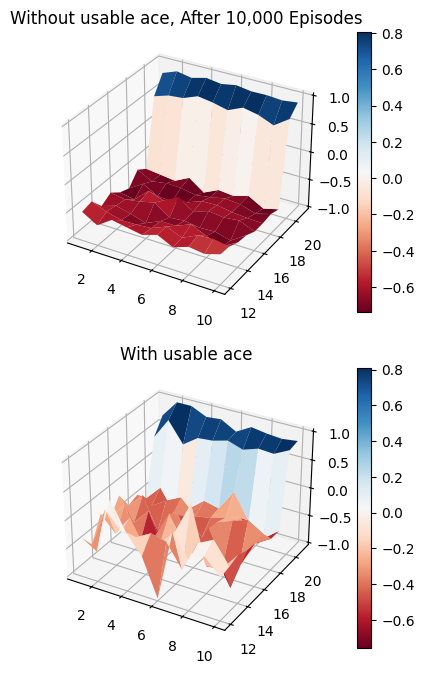

In [8]:
x, y = np.meshgrid(np.arange(1, V.shape[1]), np.arange(12, V.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
surface = ax.plot_surface(x, y, V[12:, 1:, 0], cmap='RdBu');
ax.set_title('Without usable ace, After 10,000 Episodes')
ax.set_zlim((-1, 1))
plt.colorbar(surface)

ax = fig.add_subplot(212, projection='3d')
surface = ax.plot_surface(x, y, V[12:, 1:, 1], cmap='RdBu');
ax.set_title('With usable ace');
ax.set_zlim((-1, 1))
plt.colorbar(surface);

In [9]:
V = first_visit_MC_estimation(policy, 500_000)

Episode 500000

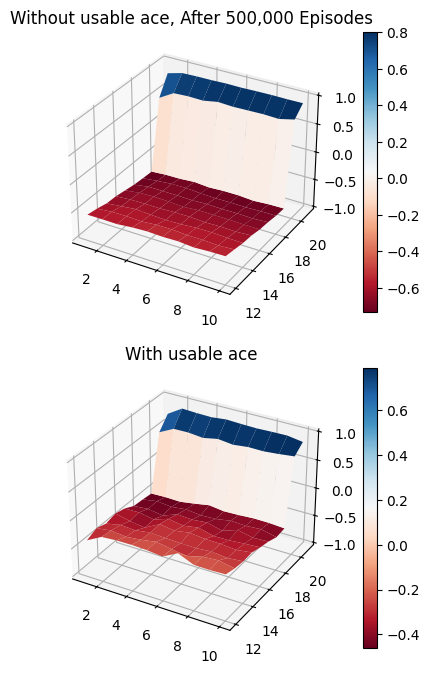

In [10]:
x, y = np.meshgrid(np.arange(1, V.shape[1]), np.arange(12, V.shape[0]))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(211, projection='3d')
surface = ax.plot_surface(x, y, V[12:, 1:, 0], cmap='RdBu');
ax.set_title('Without usable ace, After 500,000 Episodes')
ax.set_zlim((-1, 1))
plt.colorbar(surface)

ax = fig.add_subplot(212, projection='3d')
surface = ax.plot_surface(x, y, V[12:, 1:, 1], cmap='RdBu');
ax.set_title('With usable ace');
ax.set_zlim((-1, 1))
plt.colorbar(surface);